In [85]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [86]:
import tushare as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.optimize import minimize

import pdb

In [87]:
holdings = {'510050': {'name_abb': '50ETF', 'share': 10000, 'target_weight': 25, 'cost': 2.451}, 
            '159915': {'name_abb': 'CYB', 'share': 16000, 'target_weight': 25, 'cost': 1.199},
            '600030': {'name_abb': 'ZXZQ', 'share': 1000, 'target_weight': 15, 'cost': 15.005}, 
            '002415': {'name_abb': 'HKWS', 'share': 400, 'target_weight': 15, 'cost': 25.461}, 
            '002596': {'name_abb': 'HNRZ', 'share': 4000, 'target_weight': 10, 'cost': 6.838}, 
            '300137': {'name_abb': 'XHHB', 'share': 2600, 'target_weight': 10, 'cost': 7.009}}
tickers = list(holdings.keys())

new_fund = 82000

In [88]:
def mtm(holdings):
    total = 0
    for i in holdings:
        df = ts.get_realtime_quotes(i)
        name = df['name'][0]
        price = float(df['price'][0])
        holdings[i]['name'] = name
        holdings[i]['price'] = price
        holdings[i]['mtm'] = price * holdings[i]['share']
        total += holdings[i]['mtm']
    
    for i in holdings:
        #pdb.set_trace()
        holdings[i]['weight'] = round(holdings[i]['mtm'] / total, 4) * 100
        holdings[i]['Gain/Loss (%)'] = round(holdings[i]['price'] / holdings[i]['cost'] - 1, 4) *100
    
    return holdings

In [89]:
position = mtm(holdings)
df = pd.DataFrame(position).T[['name', 'price', 'cost', 'Gain/Loss (%)', 'weight', 'target_weight', 'share', 'mtm']]
df

,name,price,cost,Gain/Loss (%),weight,target_weight,share,mtm
002415,海康威视,26.35,25.461,3.49,9.02,15,400,10540
002596,海南瑞泽,5.91,6.838,-13.57,20.24,10,4000,23640
159915,创业板,1.26,1.199,5.09,17.26,25,16000,20160
300137,先河环保,7.98,7.009,13.85,17.76,10,2600,20748
510050,50ETF,2.48,2.451,1.18,21.23,25,10000,24800
600030,中信证券,16.92,15.005,12.76,14.49,15,1000,16920


In [90]:
portfolio_mtm = df['mtm'].sum()
total_value = portfolio_mtm + new_fund
portfolio_mtm

116808.0

In [91]:
fun = lambda x: (df.loc[tickers[0], 'target_weight'] - (x[0] + df.loc[tickers[0], 'mtm']) / total_value) + \
                (df.loc[tickers[1], 'target_weight'] - (x[1] + df.loc[tickers[1], 'mtm']) / total_value) + \
                (df.loc[tickers[2], 'target_weight'] - (x[2] + df.loc[tickers[2], 'mtm']) / total_value) + \
                (df.loc[tickers[3], 'target_weight'] - (x[3] + df.loc[tickers[3], 'mtm']) / total_value) + \
                (df.loc[tickers[4], 'target_weight'] - (x[4] + df.loc[tickers[4], 'mtm']) / total_value) + \
                (df.loc[tickers[5], 'target_weight'] - (x[5] + df.loc[tickers[5], 'mtm']) / total_value) 

In [92]:
cons = ({'type': 'eq', 'fun': lambda x: x[0] + x[1] + x[2] + x[3] + x[4] + x[5] - new_fund},
        {'type': 'eq', 'fun': lambda x: (x[0] + df.loc[tickers[0], 'mtm']) / total_value - df.loc[tickers[0], 'target_weight'] / 100},
        {'type': 'eq', 'fun': lambda x: (x[1] + df.loc[tickers[1], 'mtm']) / total_value - df.loc[tickers[1], 'target_weight'] / 100},
        {'type': 'eq', 'fun': lambda x: (x[2] + df.loc[tickers[2], 'mtm']) / total_value - df.loc[tickers[2], 'target_weight'] / 100},
        {'type': 'eq', 'fun': lambda x: (x[3] + df.loc[tickers[3], 'mtm']) / total_value - df.loc[tickers[3], 'target_weight'] / 100},
        {'type': 'eq', 'fun': lambda x: (x[4] + df.loc[tickers[4], 'mtm']) / total_value - df.loc[tickers[4], 'target_weight'] / 100},
        {'type': 'ineq', 'fun': lambda x: (x[0] / df.loc[tickers[0], 'price']) - 100},
        {'type': 'ineq', 'fun': lambda x: (x[1] / df.loc[tickers[1], 'price']) - 100},
        {'type': 'ineq', 'fun': lambda x: (x[2] / df.loc[tickers[2], 'price']) - 100},
        {'type': 'ineq', 'fun': lambda x: (x[3] / df.loc[tickers[3], 'price']) - 100},
        {'type': 'ineq', 'fun': lambda x: (x[4] / df.loc[tickers[4], 'price']) - 100},
        {'type': 'ineq', 'fun': lambda x: (x[5] / df.loc[tickers[5], 'price']) - 100},)
bnds = ((0, None), (0, None), (0, None), (0, None), (0, None), (0, None))

In [93]:
res = minimize(fun, (10000, 10000, 10000, 10000, 10000, 10000), method='SLSQP', bounds=bnds, constraints=cons, tol=1e-7)
res

     fun: 98.97673477188124
     jac: array([-3.81469727e-06, -3.81469727e-06, -3.81469727e-06, -5.72204590e-06,
       -3.81469727e-06, -4.76837158e-06])
 message: 'Iteration limit exceeded'
    nfev: 1798
     nit: 101
    njev: 101
  status: 9
 success: False
       x: array([24904.25042603, 29538.3832692 , 12901.63812386, 19281.04165275,
           0.        ,     0.        ])

In [94]:
if res.message == 'Optimization terminated successfully.' or sum(res.x) <= new_fund * 1.1:
    for ticker, fund in zip(tickers, res.x):
        position[ticker]['share_TBP'] = round(fund / position[ticker]['price'], -2)
        position[ticker]['weight_new'] = round(((position[ticker]['share'] + position[ticker]['share_TBP']) * position[ticker]['price']) / total_value, 4) * 100
else:
    for ticker, fund in zip(tickers, res.x):
        position[ticker]['share_TBP'] = 0
        position[ticker]['weight_new'] = position[ticker]['weight']
new_fund - sum(res.x)

-4625.313471834292

In [95]:
df = pd.DataFrame(position).T[['name', 'price', 'cost', 'Gain/Loss (%)', 'weight', 'weight_new', 'target_weight', 'share', 'share_TBP', 'mtm']]
df

,name,price,cost,Gain/Loss (%),weight,weight_new,target_weight,share,share_TBP,mtm
002415,海康威视,26.35,25.461,3.49,9.02,14.58,15,400,700,10540
002596,海南瑞泽,5.91,6.838,-13.57,20.24,11.89,10,4000,0,23640
159915,创业板,1.26,1.199,5.09,17.26,24.97,25,16000,23400,20160
300137,先河环保,7.98,7.009,13.85,17.76,10.44,10,2600,0,20748
510050,50ETF,2.48,2.451,1.18,21.23,24.95,25,10000,10000,24800
600030,中信证券,16.92,15.005,12.76,14.49,15.32,15,1000,800,16920


In [96]:
# historical analysis
start_date='2018-01-01'

In [97]:
for key in position:
    position[key]['historical_price'] = ts.get_hist_data(key, start=start_date)

<Figure size 1280x640 with 0 Axes>

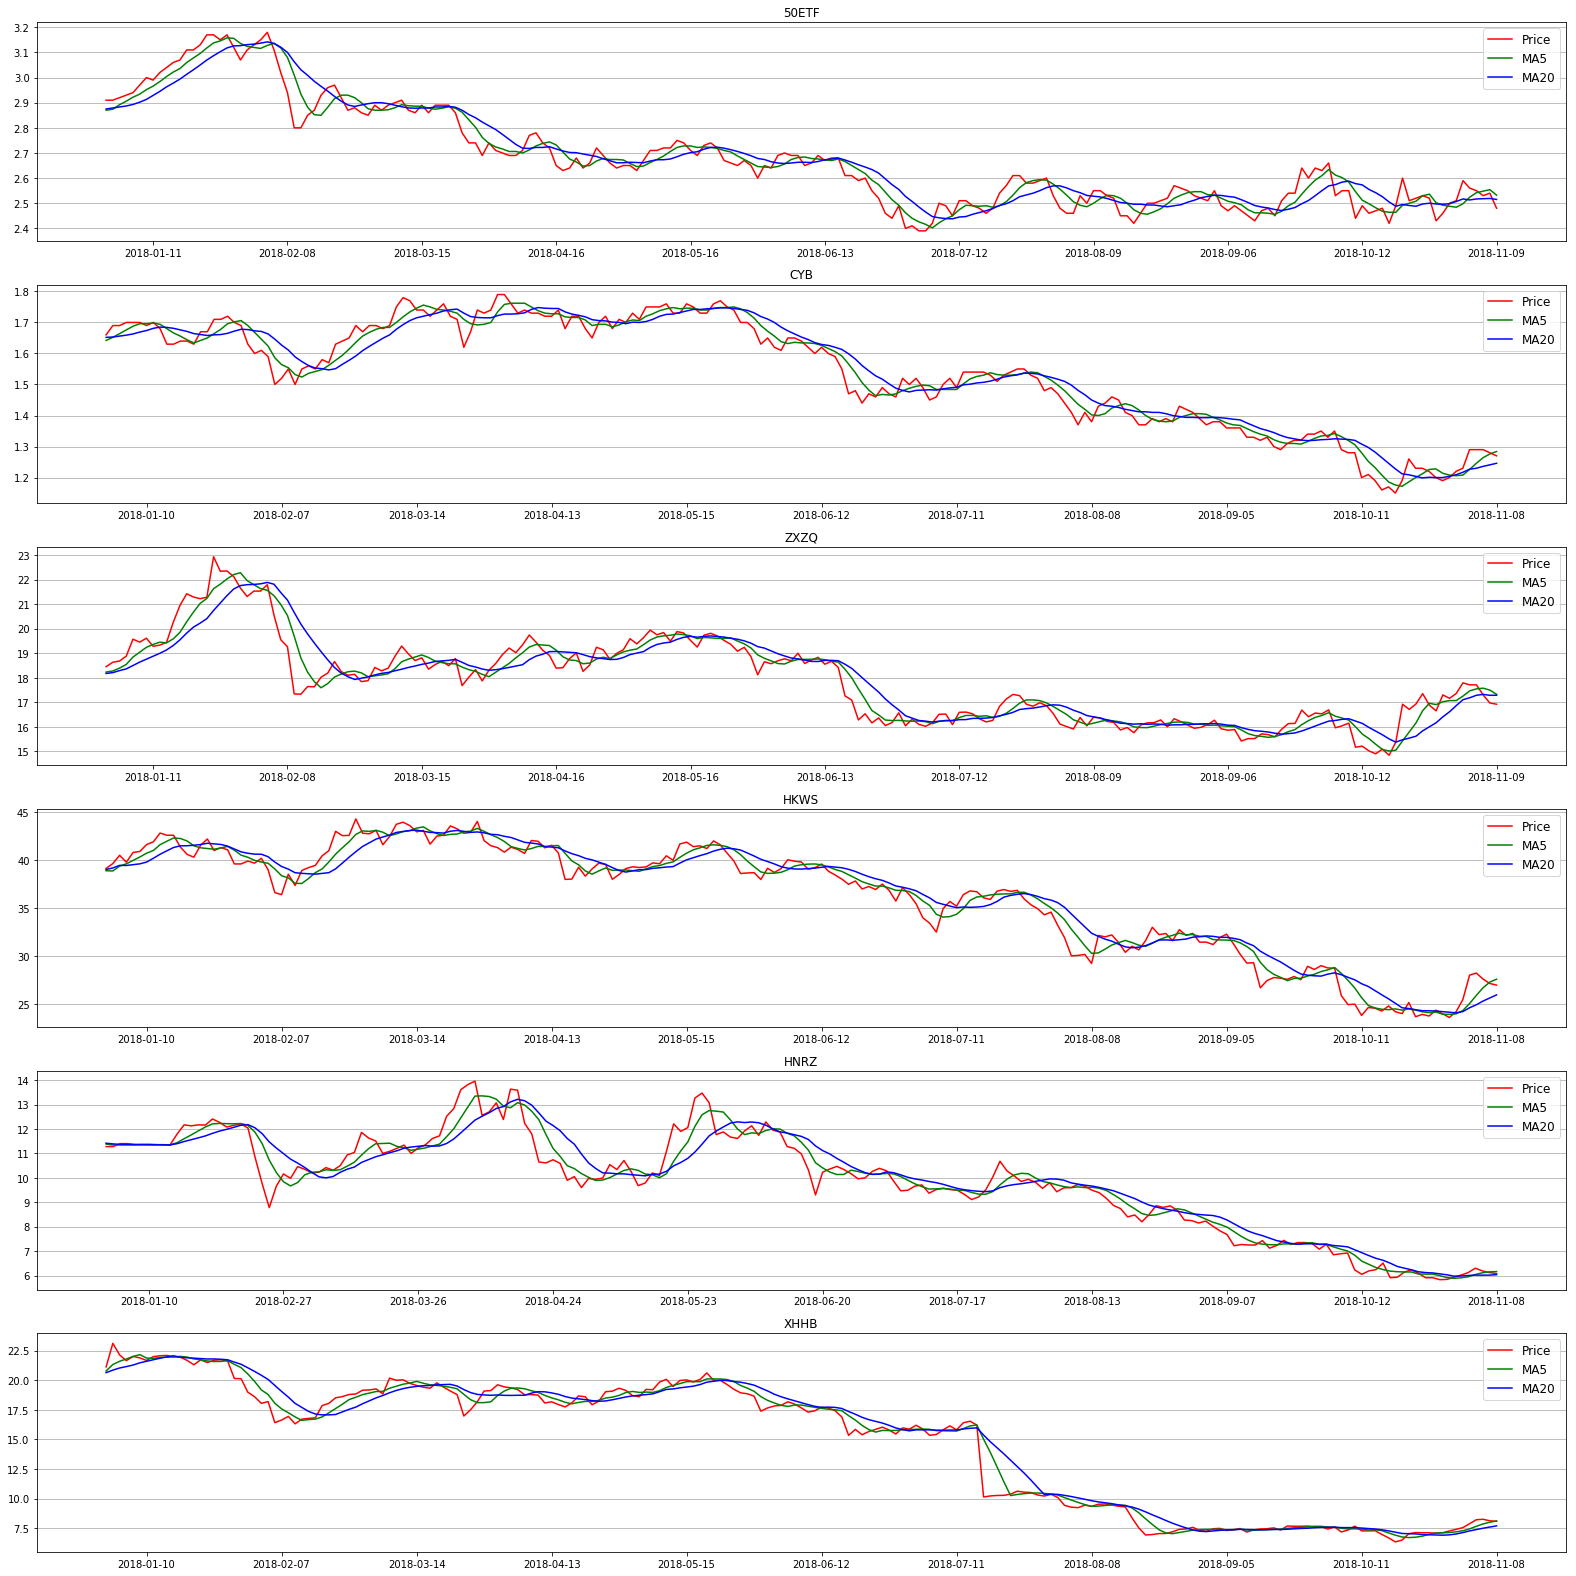

In [98]:
figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
fig, ax = plt.subplots(len(position), figsize=(22,22), sharex=False)
for i, holding in enumerate(position): 
    dates = position[holding]['historical_price'].index.tolist()[::-1]
    x_label_step = int(len(dates) / 10)
    ind = np.arange(len(dates))
    ax[i].plot(dates, position[holding]['historical_price']['close'].tolist()[::-1], color='r', label='Price')
    ax[i].plot(dates, position[holding]['historical_price']['ma5'].tolist()[::-1], color='g', label='MA5')
    ax[i].plot(dates, position[holding]['historical_price']['ma10'].tolist()[::-1], color='b', label='MA20')
    ax[i].set_xticks(ind[::-1][::x_label_step][::-1])
    ax[i].set_xticklabels(dates[::-1][::x_label_step][::-1])
    ax[i].set_title(position[holding]['name_abb'])
    ax[i].legend(loc=1, prop={'size': 12})
    ax[i].yaxis.grid()
fig.tight_layout()